# 【課題】位相推定によるスペクトル分解

In [1]:
# まず必要なモジュールをインポートする
import sys
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# ワークブック独自のモジュール
from qc_workbook.hamiltonian import make_hamiltonian
from qc_workbook.show_state import show_state

print('notebook ready')

notebook ready


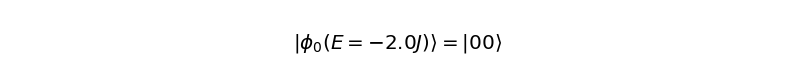

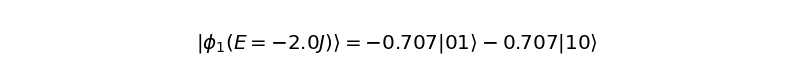

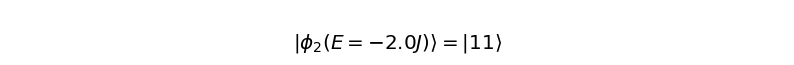

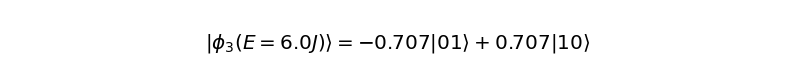

In [2]:
# Number of spins
n_s = 2
# Coupling parameter
J = 1.
# External field / J
g = 0.

# Construct the Hamiltonian matrix
paulis = list()
coeffs = list()
for j in range(n_s):
    paulis.append(list('x' if k in (j, (j + 1) % n_s) else 'i' for k in range(n_s)))
    coeffs.append(-J)
    paulis.append(list('y' if k in (j, (j + 1) % n_s) else 'i' for k in range(n_s)))
    coeffs.append(-J)
    paulis.append(list('z' if k in (j, (j + 1) % n_s) else 'i' for k in range(n_s)))
    coeffs.append(-J)
    if g != 0.:
        paulis.append(list('z' if k == j else 'i' for k in range(n_s)))
        coeffs.append(-J * g)

hamiltonian = make_hamiltonian(paulis, coeffs)

# Diagonalize and obtain the eigenvalues and vectors
eigvals, eigvectors = np.linalg.eigh(hamiltonian)

# Print the eigenvectors
for i in range(eigvals.shape[0]):
    show_state(eigvectors[:, i], binary=True, state_label=r'\phi_{} (E={}J)'.format(i, eigvals[i]))

## 問題1: スペクトル推定を実装し、厳密解と照らし合わせる

In [3]:
def trotter_twopi_heisenberg(state_register, energy_norm, g, num_steps):
    """Return a function that implements a single Trotter step for the Heisenberg model.
    
    The Heisenberg model Hamiltonian is
    H = -J * sum_of_sigmas = hbar*ω * Θ
    
    The returned circuit implements a negative time evolution
    U = exp(-i H*(-τ)/hbar)
    where τ = 2π / ω, which leads to
    U = exp(i 2π Θ).
    
    Because we employ the Suzuki-Trotter decomposition, the actual circuit corresponds to
    U = [exp(i 2π/num_steps Θ)]^num_steps.

    Args:
        state_register (QuantumRegister): Register to perform the Suzuki-Trotter simulation.
        energy_norm (float): J/(hbar*ω).
        g (float): External field strength relative to the coupling constant J.
        num_steps (float): Number of steps to divide the time evolution of ωτ=2π.

    Returns:
        QuantumCircuit: A quantum circuit implementing the Trotter simulation of the Heisenberg
        model.
    """
    circuit = QuantumCircuit(state_register, name='ΔU')

    n_spins = state_register.size
    step_size = 2. * np.pi / num_steps

    # Implement the circuit corresponding to exp(i*step_size*Θ) below, where Θ is defined by
    # Θ = -J/(hbar*ω) * sum_of_sigmas = -energy_norm * sum_of_sigmas
    ##################
    ### EDIT BELOW ###
    ##################

    phase = -energy_norm * step_size

    # circuit.?
    for j in range(n_spins):
        # ZZ
        # exp(i dphi ZZ) -> phase +dphi if parity is even
        circuit.cx(j, (j + 1) % n_spins)
        # j + 1 is |0> if parity is even -> apply Rz(-2*dphi) = exp(dphi Z)
        circuit.rz(-2. * phase, (j + 1) % n_spins)
        circuit.cx(j, (j + 1) % n_spins)

        # XX
        circuit.h(j)
        circuit.h((j + 1) % n_spins)
        circuit.cx(j, (j + 1) % n_spins)
        circuit.rz(-2. * phase, (j + 1) % n_spins)
        circuit.cx(j, (j + 1) % n_spins)
        circuit.h(j)
        circuit.h((j + 1) % n_spins)

        # YY
        circuit.p(-np.pi / 2., j)
        circuit.p(-np.pi / 2., (j + 1) % n_spins)
        circuit.h(j)
        circuit.h((j + 1) % n_spins)
        circuit.cx(j, (j + 1) % n_spins)
        circuit.rz(-2. * phase, (j + 1) % n_spins)
        circuit.cx(j, (j + 1) % n_spins)
        circuit.h(j)
        circuit.h((j + 1) % n_spins)
        circuit.p(np.pi / 2., j)
        circuit.p(np.pi / 2., (j + 1) % n_spins)

        # gZ
        if g != 0.:
            # exp(i dphi gZ)
            circuit.rz(-2. * g * phase, j)

    ##################
    ### EDIT ABOVE ###
    ##################
    
    circuit = circuit.repeat(num_steps)
    circuit.name = 'U'

    return circuit

In [4]:
def spectrum_estimation(state_register, readout_register, u_circuit):
    """Perform a spectrum estimation given a circuit containing state and readout registers and a callable implementing
    a single Trotter step.

    Args:
        state_register (QuantumRegister): State register.
        readout_register (QuantumRegister): Readout register.
        u_circuit (QuantumCircuit): A circuit implementing U_H(-2π/ω).
        
    Returns:
        QuantumCircuit: A circuit implementing the spectrum estimation of the given Hamiltonian.
    """
    circuit = QuantumCircuit(state_register, readout_register, name='Spectrum estimation')

    # Set the R register to an equal superposition
    circuit.h(readout_register)

    # Apply controlled-U operations to the circuit
    for iq, qubit in enumerate(readout_register):
        # Repeat the 2π evolution by 2^iq and convert it to a controlled gate
        controlled_u_gate = u_circuit.repeat(2 ** iq).to_gate().control(1)

        # Append the controlled gate specifying the control and target qubits
        circuit.append(controlled_u_gate, qargs=([qubit] + state_register[:]))
        
    circuit.barrier()

    # Inverse QFT
    for iq in range(readout_register.size // 2):
        circuit.swap(readout_register[iq], readout_register[-1 - iq])

    dphi = 2. * np.pi / (2 ** readout_register.size)

    for jtarg in range(readout_register.size):
        for jctrl in range(jtarg):
            power = jctrl - jtarg - 1 + readout_register.size
            circuit.cp(-dphi * (2 ** power), readout_register[jctrl], readout_register[jtarg])

        circuit.h(readout_register[jtarg])
        
    return circuit

In [5]:
## Physics model parameter
g = 0.

## Spectrum estimation parameters
# Hamiltonian normalization
energy_norm = 1. / 16. # J/(hbar*ω)
# Number of steps per 2pi evolution
# Tune this parameter to find the best balance of simulation accuracy versus circuit depth
num_steps = 6
# Register sizes
n_state = 2
n_readout = 4

## Registers
state_register = QuantumRegister(n_state, 'state')
readout_register = QuantumRegister(n_readout, 'readout')

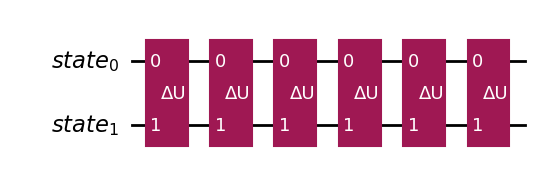

In [6]:
u_circuit = trotter_twopi_heisenberg(state_register, energy_norm, g, num_steps)
u_circuit.draw('mpl')

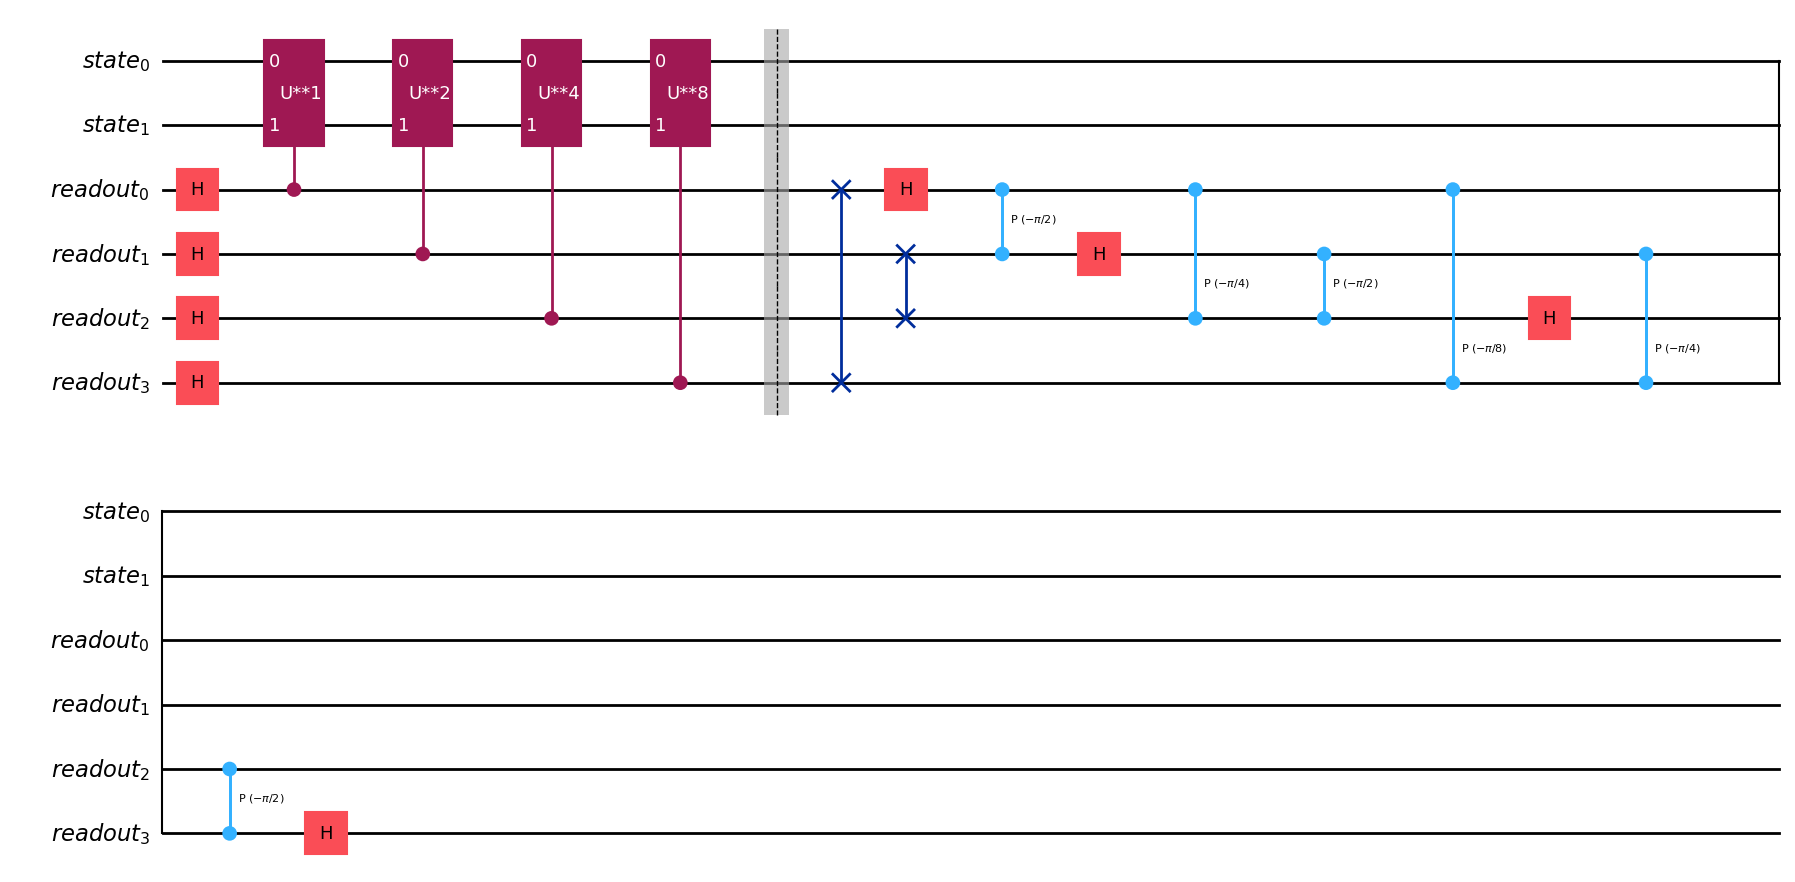

In [7]:
se_circuit = spectrum_estimation(state_register, readout_register, u_circuit)
se_circuit.draw('mpl')

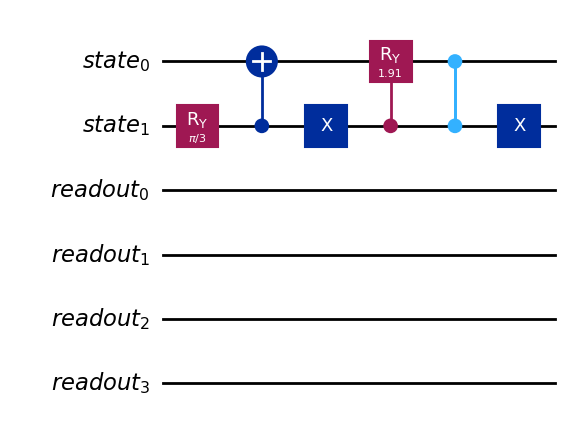

In [8]:
def make_initial_state(state_register, readout_register):
    circuit = QuantumCircuit(state_register, readout_register)

    # Set the initial state of the state vector to (1/2)|00> - (1/sqrt(2))|01> + (1/2)|11>
    ##################
    ### EDIT BELOW ###
    ##################

    #circuit.?
    circuit.ry(np.pi / 3., state_register[1])
    circuit.cx(state_register[1], state_register[0])
    circuit.x(state_register[1])
    circuit.cry(2. * np.arctan2(np.sqrt(2), 1.), state_register[1], state_register[0])
    circuit.cz(state_register[1], state_register[0])
    circuit.x(state_register[1])

    ##################
    ### EDIT ABOVE ###
    ##################
    
    return circuit


init_circuit = make_initial_state(state_register, readout_register)
init_circuit.draw('mpl')

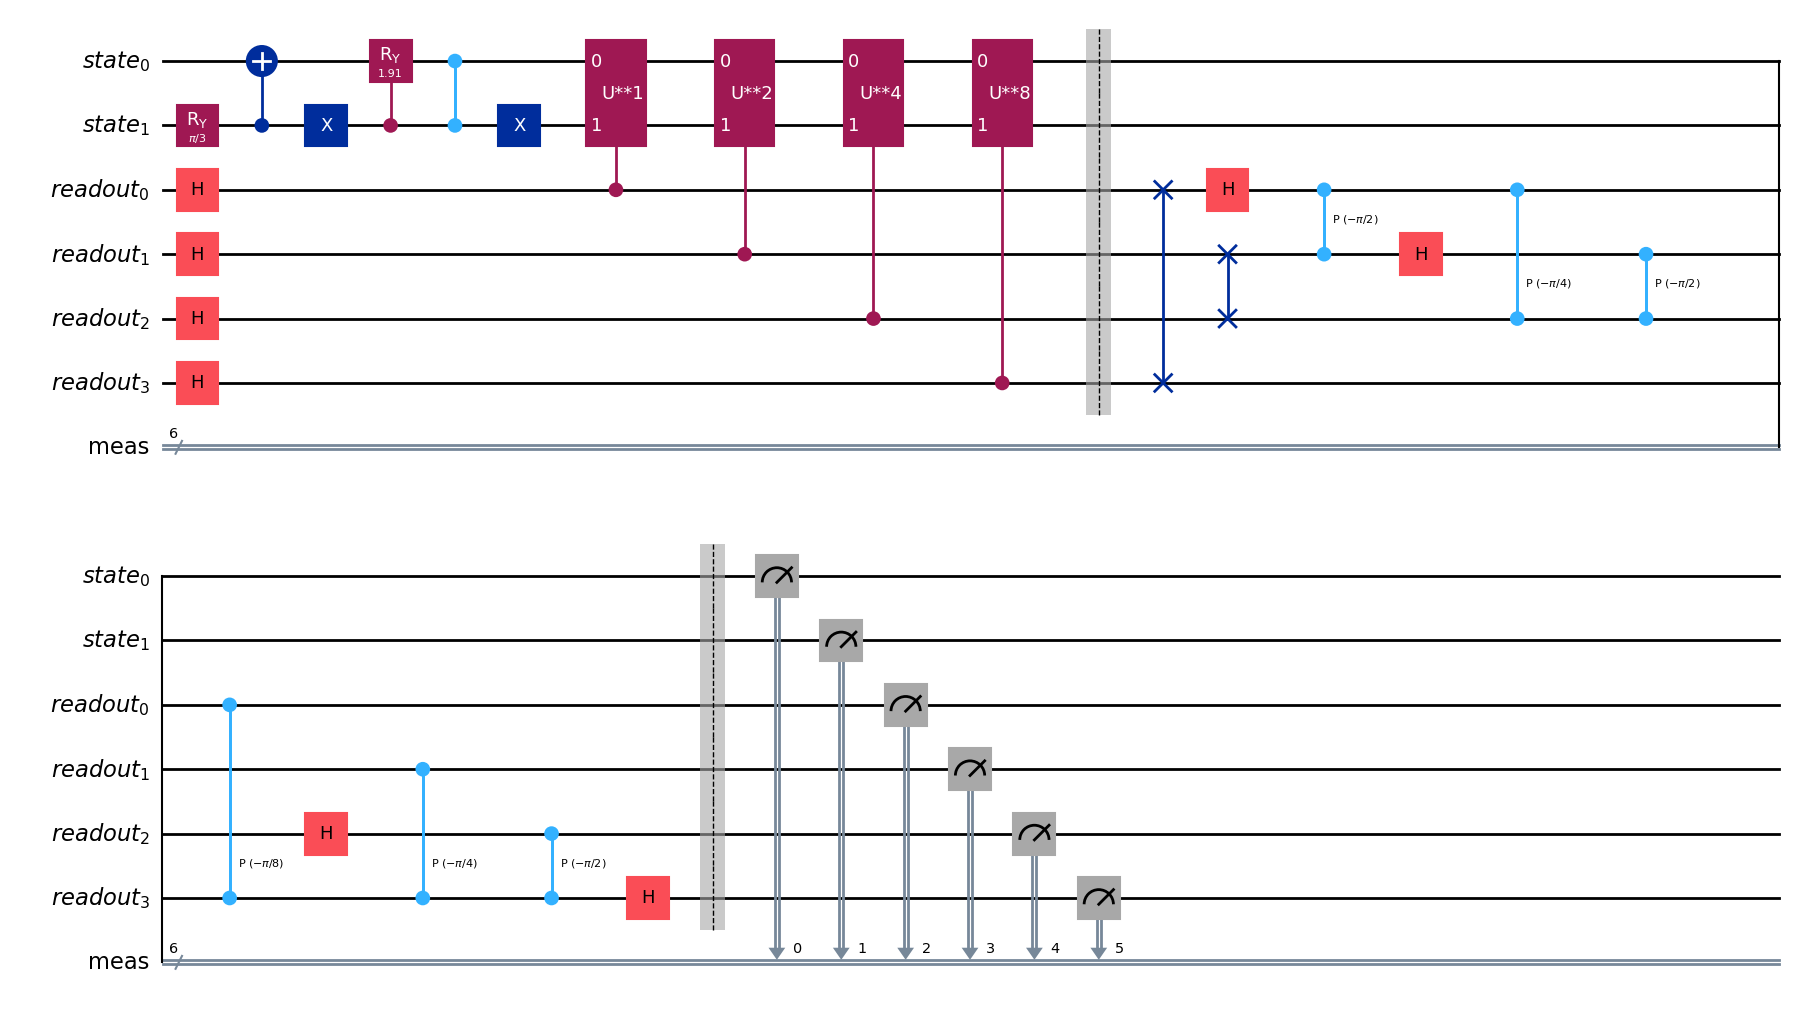

In [9]:
u_circuit = trotter_twopi_heisenberg(state_register, energy_norm, g, num_steps)
se_circuit = spectrum_estimation(state_register, readout_register, u_circuit)

circuit = make_initial_state(state_register, readout_register)
circuit.compose(se_circuit, inplace=True)
circuit.measure_all()
circuit.draw('mpl')

/opt/anaconda3/envs/env_qiskit_fy2025_code/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


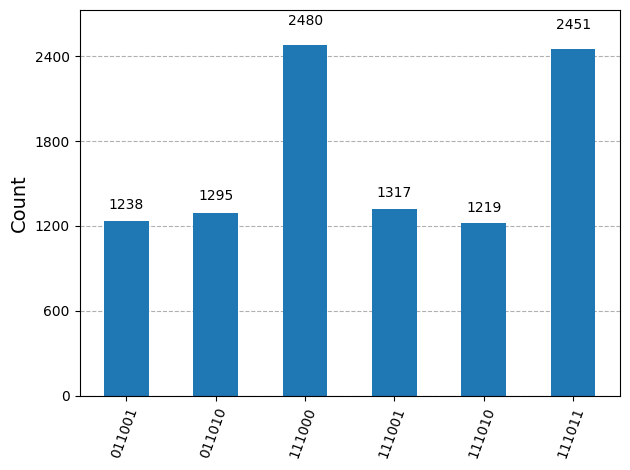

In [10]:
# Run the circuit in qasm_simulator and plot the histogram
simulator = AerSimulator()
circuit = transpile(circuit, backend=simulator)
job = simulator.run(circuit, shots=10000)
result = job.result()
counts = result.get_counts(circuit)
plot_histogram(counts)

In [11]:
def get_spectrum_for_comp_basis(
    n_state: int,
    n_readout: int,
    l: int,
    energy_norm: float,
    g: float,
    shots: int = 0
) -> np.ndarray:
    """Compute and return the distribution P_l(k, h) as an ndarray.

    Args:
        n_state: Size of the state register.
        n_readout: Size of the readout register.
        l: Index of the initial-state computational basis in the state register.
        energy_norm: Hamiltonian normalization.
        g: Parameter g of the Heisenberg model.
        shots: Number of shots. If <= 0, statevector simulation will be used.
    """

    # Define the circuit
    state_register = QuantumRegister(n_state, 'state')
    readout_register = QuantumRegister(n_readout, 'readout')
    circuit = QuantumCircuit(state_register, readout_register)

    # Initialize the state register
    for iq in range(n_state):
        if ((l >> iq) & 1) == 1:
            circuit.x(state_register[iq])

    u_circuit = trotter_twopi_heisenberg(state_register, energy_norm, g, num_steps)
    se_circuit = spectrum_estimation(state_register, readout_register, u_circuit)

    circuit.compose(se_circuit, inplace=True)

    # Extract the probability distribution as an array of shape (2 ** n_readout, 2 ** n_state)
    if shots <= 0:
        circuit.save_statevector()

        simulator = AerSimulator(method='statevector')
        circuit = transpile(circuit, backend=simulator)
        job = simulator.run(circuit)
        result = job.result()
        statevector = result.data()['statevector']

        # Convert the state vector into a probability distribution by taking the norm-squared
        probs = np.square(np.abs(statevector)).reshape((2 ** n_readout, 2 ** n_state))
        # Clean up the numerical artifacts
        probs = np.where(probs > 1.e-6, probs, np.zeros_like(probs))

    else:
        circuit.measure_all()

        # Run the circuit in simulator and plot the histogram
        simulator = AerSimulator()
        circuit = transpile(circuit, backend=simulator)
        job = simulator.run(circuit, shots=shots)
        result = job.result()
        counts = result.get_counts(circuit)

        probs = np.zeros((2 ** n_readout, 2 ** n_state), dtype=float)

        for bitstring, count in counts.items():
            readout = int(bitstring[:n_readout], 2)
            state = int(bitstring[n_readout:], 2)

            probs[readout, state] = count

        probs /= np.sum(probs)

    # probs[k, h] = P_l(k, h)
    return probs

In [12]:
n_state = 4
n_readout = 5
energy_norm = 1. / 24.

g_values = np.linspace(0., 0.5, 6, endpoint=True)

spectra = np.empty((g_values.shape[0], 2 ** n_readout), dtype=float)

def get_full_spectrum(g):
    """Compute and return the distribution P(k) for a value of g.
    """

    spectrum = np.zeros(2 ** n_readout, dtype=float)

    for l in range(2 ** n_state):
        probs = get_spectrum_for_comp_basis(n_state, n_readout, l, energy_norm, g)
        print('Computed spectrum for g = {:.1f} l = {:d}'.format(g, l))

        ##################
        ### EDIT BELOW ###
        ##################

        spectrum += np.sum(probs, axis=1)

        ##################
        ### EDIT ABOVE ###
        ##################

    return spectrum

# roll(spectrum, 2^{n_R-1}) => range of k is [-2^{n_R}/2, 2^{n_R}/2 - 1]
spectra[0] = np.roll(get_full_spectrum(0.), 2 ** (n_readout - 1))

Computed spectrum for g = 0.0 l = 0
Computed spectrum for g = 0.0 l = 1
Computed spectrum for g = 0.0 l = 2
Computed spectrum for g = 0.0 l = 3
Computed spectrum for g = 0.0 l = 4
Computed spectrum for g = 0.0 l = 5
Computed spectrum for g = 0.0 l = 6
Computed spectrum for g = 0.0 l = 7
Computed spectrum for g = 0.0 l = 8
Computed spectrum for g = 0.0 l = 9
Computed spectrum for g = 0.0 l = 10
Computed spectrum for g = 0.0 l = 11
Computed spectrum for g = 0.0 l = 12
Computed spectrum for g = 0.0 l = 13
Computed spectrum for g = 0.0 l = 14
Computed spectrum for g = 0.0 l = 15


Text(0, 0.5, 'P(E)')

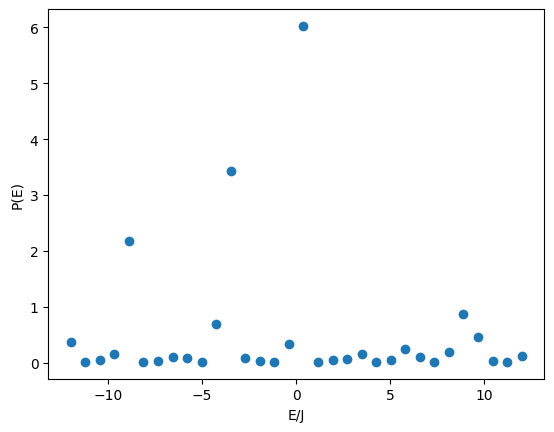

In [13]:
plt.plot(np.linspace(-0.5 / energy_norm, 0.5 / energy_norm, 2 ** n_readout), spectra[0], 'o')
plt.xlabel('E/J')
plt.ylabel('P(E)')

In [14]:
for i in range(1, g_values.shape[0]):
    spectra[i] = np.roll(get_full_spectrum(g_values[i]), 2 ** (n_readout - 1))

Computed spectrum for g = 0.1 l = 0
Computed spectrum for g = 0.1 l = 1
Computed spectrum for g = 0.1 l = 2
Computed spectrum for g = 0.1 l = 3
Computed spectrum for g = 0.1 l = 4
Computed spectrum for g = 0.1 l = 5
Computed spectrum for g = 0.1 l = 6
Computed spectrum for g = 0.1 l = 7
Computed spectrum for g = 0.1 l = 8
Computed spectrum for g = 0.1 l = 9
Computed spectrum for g = 0.1 l = 10
Computed spectrum for g = 0.1 l = 11
Computed spectrum for g = 0.1 l = 12
Computed spectrum for g = 0.1 l = 13
Computed spectrum for g = 0.1 l = 14
Computed spectrum for g = 0.1 l = 15
Computed spectrum for g = 0.2 l = 0
Computed spectrum for g = 0.2 l = 1
Computed spectrum for g = 0.2 l = 2
Computed spectrum for g = 0.2 l = 3
Computed spectrum for g = 0.2 l = 4
Computed spectrum for g = 0.2 l = 5
Computed spectrum for g = 0.2 l = 6
Computed spectrum for g = 0.2 l = 7
Computed spectrum for g = 0.2 l = 8
Computed spectrum for g = 0.2 l = 9
Computed spectrum for g = 0.2 l = 10
Computed spectrum for

Text(0, 0.5, 'P(E)')

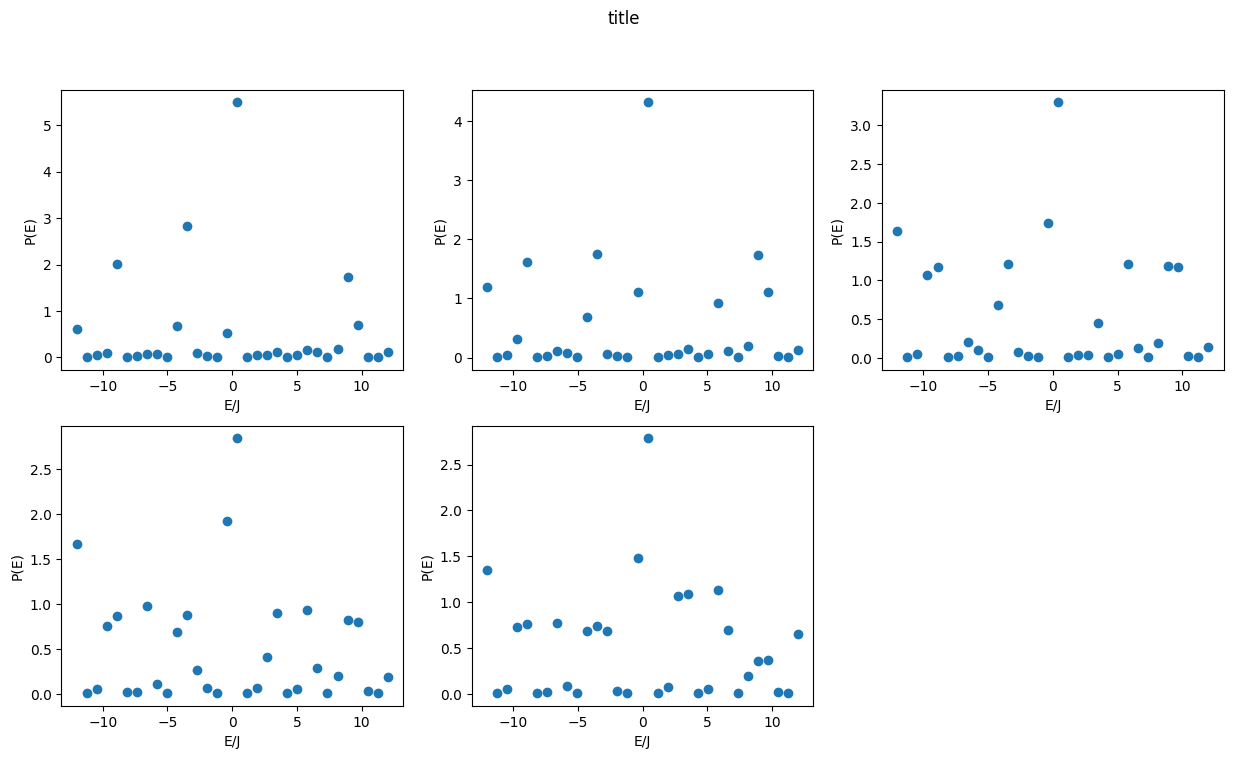

In [28]:
fig = plt.figure(figsize=(15,8))
fig.suptitle('title')
plt.subplot(2,3,1)
plt.plot(np.linspace(-0.5 / energy_norm, 0.5 / energy_norm, 2 ** n_readout), spectra[1], 'o')
plt.xlabel('E/J')
plt.ylabel('P(E)')
plt.subplot(2,3,2)
plt.plot(np.linspace(-0.5 / energy_norm, 0.5 / energy_norm, 2 ** n_readout), spectra[2], 'o')
plt.xlabel('E/J')
plt.ylabel('P(E)')
plt.subplot(2,3,3)
plt.plot(np.linspace(-0.5 / energy_norm, 0.5 / energy_norm, 2 ** n_readout), spectra[3], 'o')
plt.xlabel('E/J')
plt.ylabel('P(E)')
plt.subplot(2,3,4)
plt.plot(np.linspace(-0.5 / energy_norm, 0.5 / energy_norm, 2 ** n_readout), spectra[4], 'o')
plt.xlabel('E/J')
plt.ylabel('P(E)')
plt.subplot(2,3,5)
plt.plot(np.linspace(-0.5 / energy_norm, 0.5 / energy_norm, 2 ** n_readout), spectra[5], 'o')
plt.xlabel('E/J')
plt.ylabel('P(E)')

In [15]:
#kappa = -4. / hbar_omega * 2 ** n_readout
#nu = 5. / (2 ** n_state)
#krange = np.arange(13)

print(spectra[0])
#probs_approx = np.zeros_like(spectra[0])
#probs_approx[krange] = spectra[0][krange]

#k = np.arange(-N // 2, N // 2)
#p = np.arange(N)

[0.36249229 0.01281854 0.05262979 0.14757107 2.16957277 0.01955334
 0.02545051 0.1066654  0.08065122 0.0142263  0.69017604 3.43609985
 0.09146303 0.03681527 0.01448831 0.33181905 6.02716965 0.01317452
 0.05022921 0.06285827 0.14893783 0.01618875 0.05569233 0.23674148
 0.10305138 0.01316972 0.19480514 0.86783473 0.46400531 0.02545963
 0.01758195 0.11060191]


In [ ]:
energy_eigenvalues = np.empty((g_values.shape[0], 2 ** n_state))

# Extract the energy eigenvalues from spectra and fill the array
##################
### EDIT BELOW ###
##################

#energy_eigenvalues[ig, m] = E_ig_m

##################
### EDIT ABOVE ###
##################

plt.plot(g_values, energy_eigenvalues)

**提出するもの**

- 完成した`trotter_twopi_heisenberg`関数
- 完成した状態レジスタの初期化回路
- スペクトル推定の結果のヒストグラムと、その解釈

**スペクトル推定の結果の解釈**

